## IMPORT LIBRARY


In [ ]:
# Import Library
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

## LOAD DATASET

Dataset avaiable in : [https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered)

In [ ]:
# Hubungkan Drive
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dataset 224x224

/content/drive/MyDrive/dataset 224x224


## PRE-PROCESSING

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv('train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.2, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.2 / (1 - 0.2), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1083
Moderate           599
Mild               222
Proliferate_DR     177
Severe             115
Name: type, dtype: int64 

No_DR             361
Moderate          200
Mild               74
Proliferate_DR     59
Severe             39
Name: type, dtype: int64 

No_DR             361
Moderate          200
Mild               74
Proliferate_DR     59
Severe             39
Name: type, dtype: int64 



In [ ]:
# Melihat daftar excel
df = pd.read_csv('train.csv')
print(df)

           id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
3657  ffa47f6a7bf4          2
3658  ffc04fed30e6          0
3659  ffcf7b45f213          2
3660  ffd97f8cd5aa          0
3661  ffec9a18a3ce          2

[3662 rows x 2 columns]


In [ ]:
# Membuat directory untuk data latih, data validasi dan data tes
base_dir = ''
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
# Menyalin gambar ke masing-masing directory sesuai data latih, data validasi dan data tes

src_dir = r"/content/drive/MyDrive/dataset 224x224/gaussian_filtered_images/gaussian_filtered_images"

for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2196 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


## MODELLING

###Convolutional Neural Network

In [ ]:
# Buat model
model = tf.keras.Sequential([
    layers.Conv2D(8, (2,2), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (2,2), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (2,2), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (2,2), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation = 'softmax')
])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 223, 223, 8)       104       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 8)      0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 111, 111, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 110, 110, 16)      528       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 16)       0         
 g2D)                                                            
                                                      

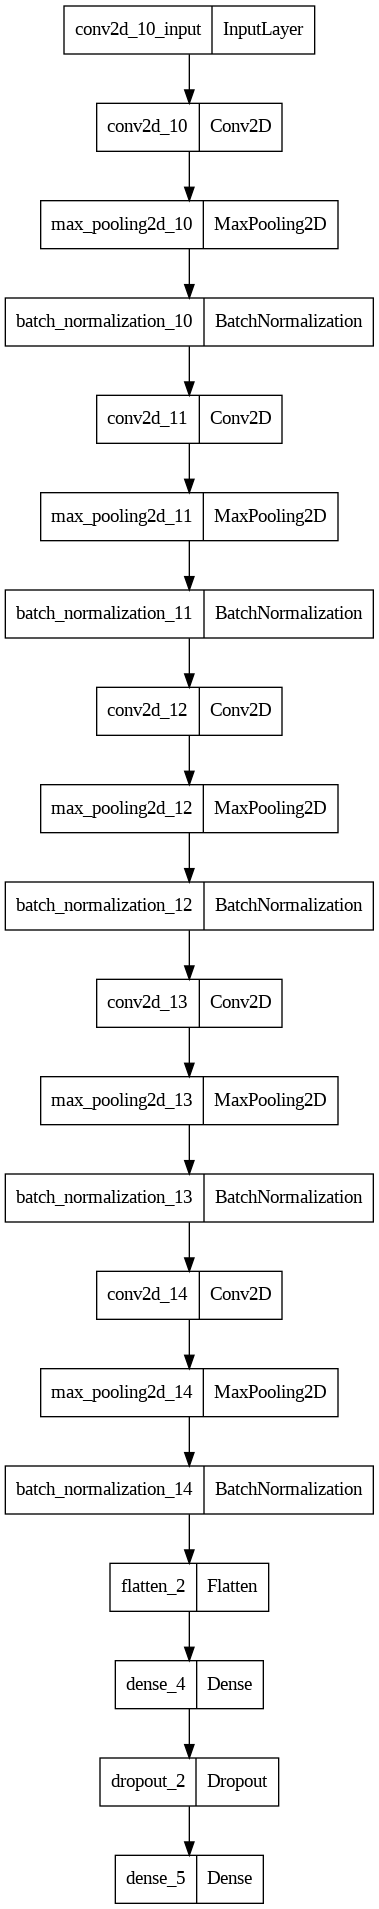

In [ ]:
# Flowchart Model
print(model.summary())
tf.keras.utils.plot_model(model)

In [ ]:
# Melatih model
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/25
69/69 [==============================] - 53s 693ms/step - loss: 0.2903 - acc: 0.9021 - val_loss: 0.7338 - val_acc: 0.4925
Epoch 2/25
69/69 [==============================] - 50s 729ms/step - loss: 0.1708 - acc: 0.9413 - val_loss: 1.2442 - val_acc: 0.4925
Epoch 3/25
69/69 [==============================] - 47s 678ms/step - loss: 0.1304 - acc: 0.9495 - val_loss: 0.6352 - val_acc: 0.5321
Epoch 4/25
69/69 [==============================] - 48s 701ms/step - loss: 0.1019 - acc: 0.9636 - val_loss: 1.5026 - val_acc: 0.4925
Epoch 5/25
69/69 [==============================] - 51s 730ms/step - loss: 0.0610 - acc: 0.9841 - val_loss: 0.4370 - val_acc: 0.8377
Epoch 6/25
69/69 [==============================] - 47s 680ms/step - loss: 0.0420 - acc: 0.9845 - val_loss: 0.3616 - val_acc: 0.8458
Epoch 7/25
69/69 [==============================] - 52s 753ms/step - loss: 0.0118 - acc: 0.9977 - val_loss: 0.2453 - val_acc: 0.8868
Epoch 8/25
69/69 [==============================] - 55s 797ms/step - 

## ACCURACY

In [ ]:
# Akurasi Data Train
loss, acc = model.evaluate_generator(train_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)


<ipython-input-42-a22f543bb4f2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(train_batches, verbose=1)


69/69 [==============================] - 19s 270ms/step - loss: 6.5105e-04 - acc: 0.9995
Loss:  0.0006510482635349035
Accuracy:  0.999544620513916


In [ ]:
# Akurasi Data Test
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-43-3b5ecb17abf5>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


23/23 [==============================] - 6s 235ms/step - loss: 0.3205 - acc: 0.9482
Loss:  0.3204784393310547
Accuracy:  0.9481582641601562
